### 120316_0855
* repeat of first run without regularization; added history and metrics tracking

### 120316_0000
* change to run with regularization

### 120116_1223
* run with cleaned dataset, just on damage severity, 256x256, 8 batch size, theano backend
* loss: 0.5195 - acc: 0.7763 - val_loss: 0.5586 - val_acc: 0.7544

In [2]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
from sklearn.metrics import classification_report, confusion_matrix

sns.set_palette("cubehelix")
sns.set_style('whitegrid')

In [3]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is enabled)


In [4]:
def load_vgg16(weights_path='../vgg16_weights.h5'):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
      
    # assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'
    
    if weights_path:
    # note: this chops off the last layers of VGG16 
        f = h5py.File(weights_path)
        for k in range(f.attrs['nb_layers']):
            if k >= len(model.layers): 
                # we don't look at the last (fully-connected) layers in the savefile
                break
            g = f['layer_{}'.format(k)]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.layers[k].set_weights(weights)
        f.close()
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.')

    return model

In [5]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16,
                                            class_mode=None, 
                                            shuffle=False) 

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    np.save(open(location+'/bottleneck_features_train.npy', 'w'), bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    np.save(open(location+'/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

In [6]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print 'epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch]

In [7]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print "Best Model:" 
    print_best_model_results(hist)

In [8]:
def train_categorical_model():
    train_data = np.load(open(location+'/bottleneck_features_train.npy'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy'))
    validation_labels = np.array([0] * (validation_samples[0]) + 
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax')) # upped to 3 and activation softmax

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9), # reduced learning rate
              loss='categorical_crossentropy', metrics=['accuracy'])

    # model.compile(optimizer='rmsprop', 
    #               loss='categorical_crossentropy', metrics=['accuracy']) 
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [9]:
def finetune_categorical_model():
    model = load_vgg16()

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False

    model.compile(loss='categorical_crossentropy',
                 optimizer = optimizers.SGD(lr=0.000001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
        
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              samples_per_epoch=nb_train_samples,
                              nb_epoch=nb_epoch,
                              validation_data=validation_generator,
                              nb_val_samples=nb_validation_samples,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [10]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)

    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [11]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = raw_input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

## Defining Input Data

In [12]:
# path to the model weights file
location = 'data3_1'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50

In [12]:
# do not rerun!
save_bottleneck_features(location)

VGG16 Model with partial weights loaded.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


## Model Parameter Selection

In [18]:
# WINNER
d3_model2, d3_hist2 = train_categorical_model() # no regularization

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 0s - loss: 1.1776 - acc: 0.4045 - val_loss: 1.0011 - val_acc: 0.5439
Epoch 2/50
979/979 [==============================] - 0s - loss: 1.0117 - acc: 0.4934 - val_loss: 0.9500 - val_acc: 0.5439
Epoch 3/50
979/979 [==============================] - 0s - loss: 0.8940 - acc: 0.5965 - val_loss: 0.9063 - val_acc: 0.5497
Epoch 4/50
979/979 [==============================] - 0s - loss: 0.8550 - acc: 0.5975 - val_loss: 0.8550 - val_acc: 0.6491
Epoch 5/50
979/979 [==============================] - 0s - loss: 0.8274 - acc: 0.6088 - val_loss: 0.8612 - val_acc: 0.5789
Epoch 6/50
979/979 [==============================] - 0s - loss: 0.8135 - acc: 0.6364 - val_loss: 0.8547 - val_acc: 0.5848
Epoch 7/50
979/979 [==============================] - 0s - loss: 0.7859 - acc: 0.6558 - val_loss: 0.8250 - val_acc: 0.5965
Epoch 8/50
979/979 [==============================] - 0s - loss: 0.7317 - acc: 0.6721 - val_l

In [43]:
d3_model, d3_hist = train_categorical_model() # l2 regularization, sgd lr = 0.0001

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 1s - loss: 6.2923 - acc: 0.4096 - val_loss: 0.9706 - val_acc: 0.6199
Epoch 2/50
979/979 [==============================] - 1s - loss: 6.0341 - acc: 0.5281 - val_loss: 0.9172 - val_acc: 0.6491
Epoch 3/50
979/979 [==============================] - 1s - loss: 5.9608 - acc: 0.5628 - val_loss: 0.8912 - val_acc: 0.5439
Epoch 4/50
979/979 [==============================] - 1s - loss: 5.8929 - acc: 0.6047 - val_loss: 0.8752 - val_acc: 0.5556
Epoch 5/50
979/979 [==============================] - 1s - loss: 5.8612 - acc: 0.6180 - val_loss: 0.8530 - val_acc: 0.6316
Epoch 6/50
979/979 [==============================] - 1s - loss: 5.7856 - acc: 0.6517 - val_loss: 0.8293 - val_acc: 0.6374
Epoch 7/50
979/979 [==============================] - 1s - loss: 5.7495 - acc: 0.6813 - val_loss: 0.8339 - val_acc: 0.5965
Epoch 8/50
979/979 [==============================] - 1s - loss: 5.7437 - acc: 0.6619 - val_l

In [22]:
d3_model3, d3_hist3 = train_categorical_model() # l1 regularization

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 1s - loss: 547.7880 - acc: 0.4127 - val_loss: 0.9907 - val_acc: 0.5088
Epoch 2/50
979/979 [==============================] - 1s - loss: 498.8393 - acc: 0.5169 - val_loss: 0.9264 - val_acc: 0.5146
Epoch 3/50
979/979 [==============================] - 1s - loss: 451.1974 - acc: 0.5557 - val_loss: 0.8945 - val_acc: 0.5789
Epoch 4/50
979/979 [==============================] - 1s - loss: 405.9638 - acc: 0.5975 - val_loss: 0.8707 - val_acc: 0.6023
Epoch 5/50
979/979 [==============================] - 1s - loss: 363.1416 - acc: 0.6108 - val_loss: 0.8534 - val_acc: 0.5731
Epoch 6/50
979/979 [==============================] - 1s - loss: 322.6832 - acc: 0.6415 - val_loss: 0.8444 - val_acc: 0.5906
Epoch 7/50
979/979 [==============================] - 1s - loss: 284.6990 - acc: 0.6313 - val_loss: 0.8649 - val_acc: 0.5673
Epoch 8/50
979/979 [==============================] - 1s - loss: 249.0346 - acc

In [26]:
d3_model4, d3_hist4 = train_categorical_model() # double dense and dropout layers

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 0s - loss: 1.2650 - acc: 0.3585 - val_loss: 1.0652 - val_acc: 0.4269
Epoch 2/50
979/979 [==============================] - 0s - loss: 1.0999 - acc: 0.3892 - val_loss: 1.0423 - val_acc: 0.4678
Epoch 3/50
979/979 [==============================] - 0s - loss: 1.0637 - acc: 0.4321 - val_loss: 1.0414 - val_acc: 0.4737
Epoch 4/50
979/979 [==============================] - 0s - loss: 1.0381 - acc: 0.4556 - val_loss: 1.0045 - val_acc: 0.5380
Epoch 5/50
979/979 [==============================] - 0s - loss: 1.0255 - acc: 0.4668 - val_loss: 0.9681 - val_acc: 0.5906
Epoch 6/50
979/979 [==============================] - 0s - loss: 0.9955 - acc: 0.5107 - val_loss: 0.9555 - val_acc: 0.5731
Epoch 7/50
979/979 [==============================] - 0s - loss: 0.9937 - acc: 0.5005 - val_loss: 0.9399 - val_acc: 0.5906
Epoch 8/50
979/979 [==============================] - 0s - loss: 0.9850 - acc: 0.5036 - val_l

In [29]:
d3_model5, d3_hist5 = train_categorical_model() # double dense and dropout layers with regularization

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 1s - loss: 8.8472 - acc: 0.3514 - val_loss: 1.0879 - val_acc: 0.3216
Epoch 2/50
979/979 [==============================] - 1s - loss: 8.6967 - acc: 0.3922 - val_loss: 1.0286 - val_acc: 0.4503
Epoch 3/50
979/979 [==============================] - 1s - loss: 8.6266 - acc: 0.4423 - val_loss: 0.9922 - val_acc: 0.5380
Epoch 4/50
979/979 [==============================] - 1s - loss: 8.5941 - acc: 0.4668 - val_loss: 1.0023 - val_acc: 0.6140
Epoch 5/50
979/979 [==============================] - 1s - loss: 8.5421 - acc: 0.4821 - val_loss: 0.9478 - val_acc: 0.5614
Epoch 6/50
979/979 [==============================] - 1s - loss: 8.5030 - acc: 0.5179 - val_loss: 0.9388 - val_acc: 0.5965
Epoch 7/50
979/979 [==============================] - 1s - loss: 8.4722 - acc: 0.5189 - val_loss: 0.9287 - val_acc: 0.6082
Epoch 8/50
979/979 [==============================] - 1s - loss: 8.4357 - acc: 0.5506 - val_l

In [33]:
d3_model6, d3_hist6 = train_categorical_model() # double dense with aggressive dropout

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 0s - loss: 1.5132 - acc: 0.3391 - val_loss: 1.0902 - val_acc: 0.4211
Epoch 2/50
979/979 [==============================] - 0s - loss: 1.1146 - acc: 0.3647 - val_loss: 1.0951 - val_acc: 0.4211
Epoch 3/50
979/979 [==============================] - 0s - loss: 1.1009 - acc: 0.3677 - val_loss: 1.0934 - val_acc: 0.3977
Epoch 4/50
979/979 [==============================] - 0s - loss: 1.0998 - acc: 0.3841 - val_loss: 1.0965 - val_acc: 0.4094
Epoch 5/50
979/979 [==============================] - 0s - loss: 1.0997 - acc: 0.3851 - val_loss: 1.0966 - val_acc: 0.3918
Epoch 6/50
979/979 [==============================] - 0s - loss: 1.0980 - acc: 0.3830 - val_loss: 1.0868 - val_acc: 0.4152
Epoch 7/50
979/979 [==============================] - 0s - loss: 1.0998 - acc: 0.4035 - val_loss: 1.0955 - val_acc: 0.3918
Epoch 8/50
979/979 [==============================] - 0s - loss: 1.0956 - acc: 0.3810 - val_l

In [36]:
d3_model7, d3_hist7 = train_categorical_model() # l2 regularization and aggresive dropout

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 1s - loss: 6.3256 - acc: 0.3994 - val_loss: 1.0454 - val_acc: 0.3977
Epoch 2/50
979/979 [==============================] - 1s - loss: 6.1301 - acc: 0.4372 - val_loss: 1.0185 - val_acc: 0.5380
Epoch 3/50
979/979 [==============================] - 1s - loss: 6.0741 - acc: 0.4678 - val_loss: 0.9916 - val_acc: 0.5965
Epoch 4/50
979/979 [==============================] - 1s - loss: 6.0515 - acc: 0.4842 - val_loss: 0.9564 - val_acc: 0.5673
Epoch 5/50
979/979 [==============================] - 1s - loss: 6.0053 - acc: 0.5087 - val_loss: 0.9307 - val_acc: 0.5906
Epoch 6/50
979/979 [==============================] - 1s - loss: 5.9727 - acc: 0.5189 - val_loss: 0.9168 - val_acc: 0.6023
Epoch 7/50
979/979 [==============================] - 1s - loss: 5.9399 - acc: 0.5557 - val_loss: 0.9078 - val_acc: 0.5848
Epoch 8/50
979/979 [==============================] - 1s - loss: 5.9146 - acc: 0.5577 - val_l

In [39]:
d3_model8, d3_hist8 = train_categorical_model() # l2 regularization, rmsprop

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 1s - loss: 10.5279 - acc: 0.3861 - val_loss: 9.7086 - val_acc: 0.3977
Epoch 2/50
979/979 [==============================] - 1s - loss: 6.4850 - acc: 0.3790 - val_loss: 0.9769 - val_acc: 0.4971
Epoch 3/50
979/979 [==============================] - 1s - loss: 1.9286 - acc: 0.4872 - val_loss: 1.7564 - val_acc: 0.4035
Epoch 4/50
979/979 [==============================] - 1s - loss: 1.8148 - acc: 0.4699 - val_loss: 1.0865 - val_acc: 0.4620
Epoch 5/50
979/979 [==============================] - 1s - loss: 1.9886 - acc: 0.5077 - val_loss: 1.4189 - val_acc: 0.4854
Epoch 6/50
979/979 [==============================] - 1s - loss: 1.8371 - acc: 0.5107 - val_loss: 1.0879 - val_acc: 0.5673
Epoch 7/50
979/979 [==============================] - 1s - loss: 1.8215 - acc: 0.5281 - val_loss: 0.8840 - val_acc: 0.5848
Epoch 8/50
979/979 [==============================] - 1s - loss: 1.9564 - acc: 0.5077 - val_

Best Model:
epoch: 13 , val_acc: 0.666666668061 , val_loss: 0.742396930156


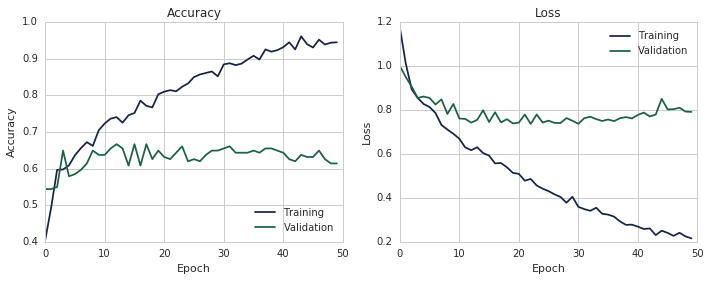

In [19]:
# WINNER
plot_metrics(d3_hist2)

Best Model:
epoch: 27 , val_acc: 0.678362572751 , val_loss: 0.764172005375


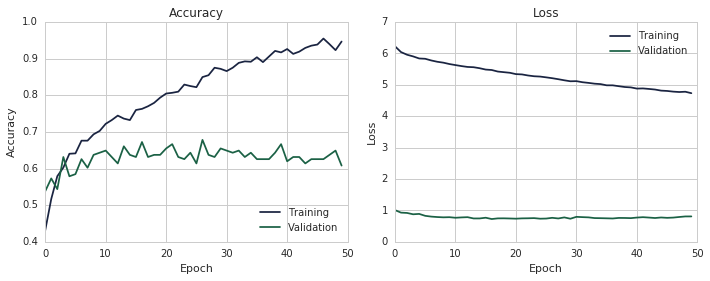

In [15]:
plot_metrics(d3_hist)

Best Model:
epoch: 15 , val_acc: 0.654970761977 , val_loss: 0.830861142504


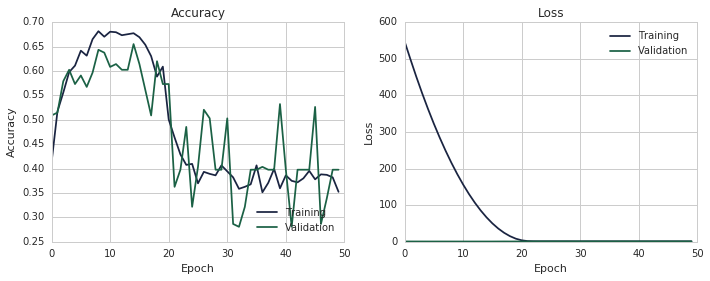

In [23]:
plot_metrics(d3_hist3)

Best Model:
epoch: 36 , val_acc: 0.672514619534 , val_loss: 0.748187764346


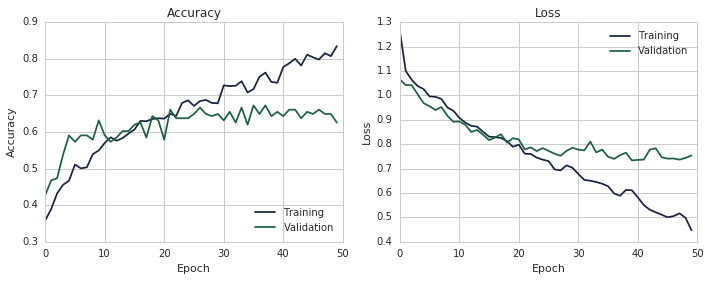

In [27]:
plot_metrics(d3_hist4)

Best Model:
epoch: 21 , val_acc: 0.660818713102 , val_loss: 0.777828329836


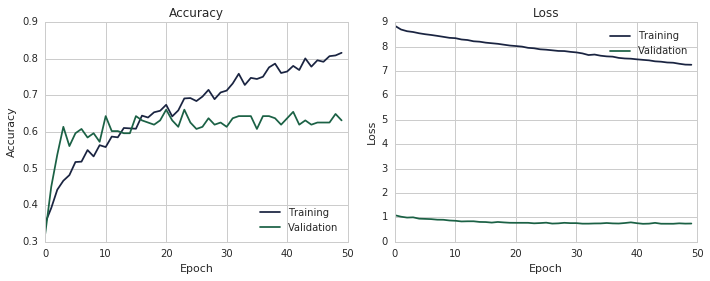

In [30]:
plot_metrics(d3_hist5)

Best Model:
epoch: 1 , val_acc: 0.421052632276 , val_loss: 1.09023717412


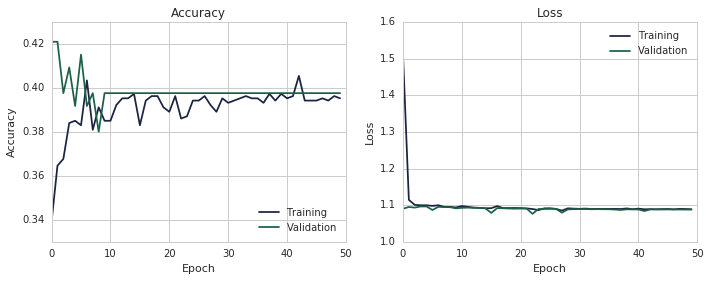

In [34]:
plot_metrics(d3_hist6)

Best Model:
epoch: 11 , val_acc: 0.666666668409 , val_loss: 0.849356167498


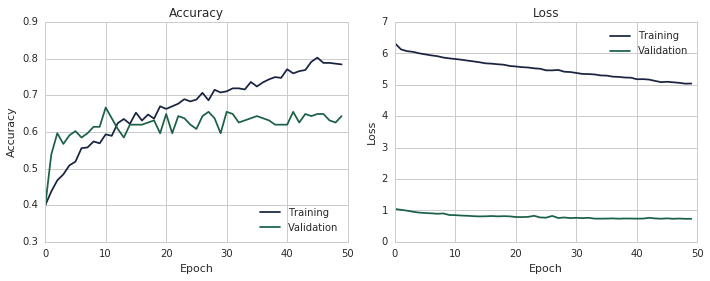

In [37]:
plot_metrics(d3_hist7)

Best Model:
epoch: 14 , val_acc: 0.649122808412 , val_loss: 0.839906761172


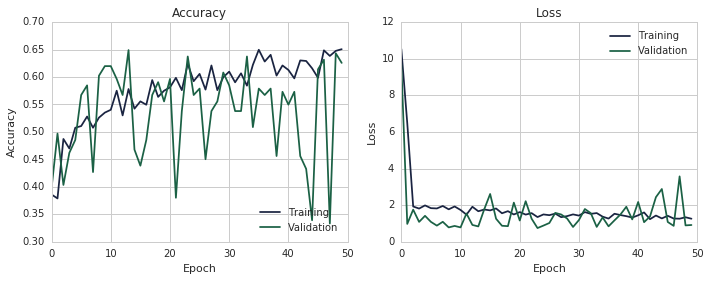

In [41]:
plot_metrics(d3_hist8)

## Finetuning Model

### Run 1 - With Regularization

Best Model:
epoch: 44 , val_acc: 0.70760233953 , val_loss: 0.663656747132


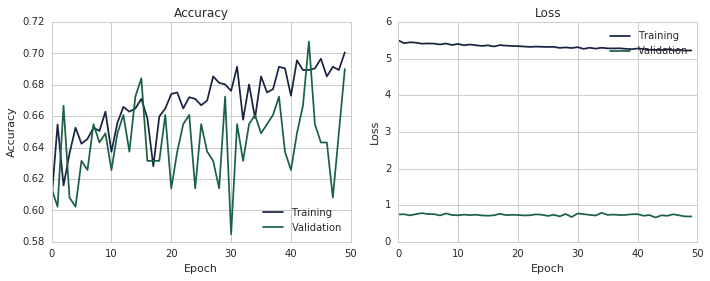

In [46]:
plot_metrics(ft_d3_hist)

### Run 2 - Without Regularization

In [20]:
ft_d3_model, ft_d3_hist = finetune_categorical_model()

VGG16 Model with partial weights loaded.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
979/979 [==============================] - 89s - loss: 0.8841 - acc: 0.5689 - val_loss: 0.7774 - val_acc: 0.6433
Epoch 2/50
979/979 [==============================] - 88s - loss: 0.8668 - acc: 0.5975 - val_loss: 0.7866 - val_acc: 0.6374
Epoch 3/50
979/979 [==============================] - 89s - loss: 0.8341 - acc: 0.6221 - val_loss: 0.7475 - val_acc: 0.6550
Epoch 4/50
979/979 [==============================] - 88s - loss: 0.8081 - acc: 0.6149 - val_loss: 0.7331 - val_acc: 0.6199
Epoch 5/50
979/979 [==============================] - 89s - loss: 0.8252 - acc: 0.6067 - val_loss: 0.7337 - val_acc: 0.6667
Epoch 6/50
979/979 [==============================] - 88s - loss: 0.8135 - acc: 0.6210 - val_loss: 0.7254 - val_acc: 0.6608
Epoch 7/50
979/979 [==============================] - 88s - loss: 0.8285 - acc: 0.6159 - val_loss: 0.7241 - val_acc: 0.6550
Epoch 8/5

Best Model:
epoch: 38 , val_acc: 0.713450292572 , val_loss: 0.705431878218


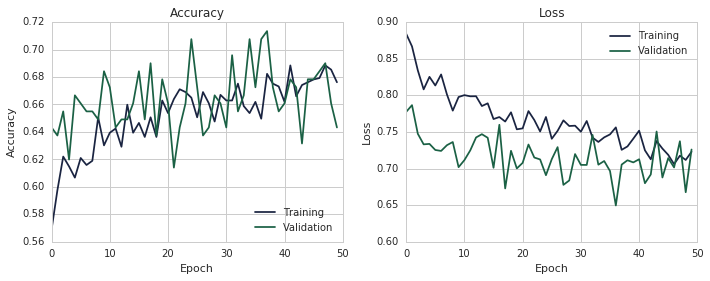

In [21]:
plot_metrics(ft_d3_hist)

## Model Evaluation

In [34]:
ft_d3_model = load_model('data3_1/120116_1223/ft_d3_model.h5') # without regularization, first run

In [76]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.83      0.60      0.70        48
          1       0.51      0.56      0.53        55
          2       0.73      0.81      0.77        68

avg / total       0.69      0.67      0.67       171




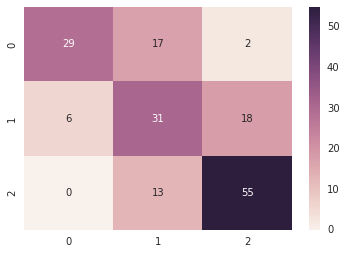

In [36]:
evaluate_categorical_model(ft_d3_model, validation_data_dir, validation_labels) 

In [37]:
ft_d3_model2 = load_model('data3_1/120316_0000/ft_model.h5') # with regularization, first run

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.79      0.62      0.70        48
          1       0.49      0.65      0.56        55
          2       0.78      0.69      0.73        68

avg / total       0.69      0.66      0.67       171




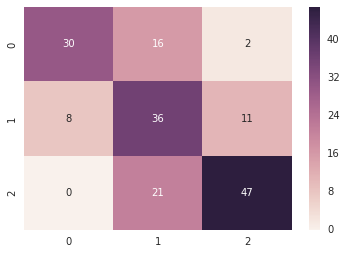

In [38]:
evaluate_categorical_model(ft_d3_model2, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.79      0.71      0.75        48
          1       0.53      0.65      0.59        55
          2       0.80      0.71      0.75        68

avg / total       0.71      0.69      0.70       171




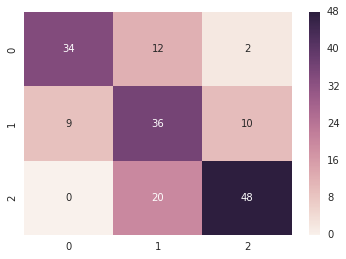

In [40]:
evaluate_categorical_model(ft_d3_model3, validation_data_dir, validation_labels)

## Load Model Point

In [40]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
           
    print "Best Model:" 
    print_best_model_results(hist)

In [14]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [15]:
# WINNER
ft_model = load_model('data3_1/ft_model.h5')  # without regularization, second run

In [16]:
with open('data3_1/ft_history.txt') as f:    
    ft_history = json.load(f)

In [18]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [19]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.79      0.71      0.75        48
          1       0.53      0.65      0.59        55
          2       0.80      0.71      0.75        68

avg / total       0.71      0.69      0.70       171




In [48]:
with open('data3_1/top_history.txt') as f:    
    top_history = json.load(f)

def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,7))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

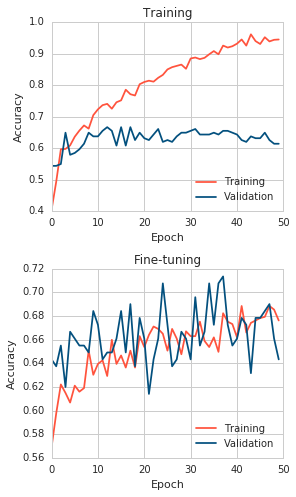

In [49]:
plot_acc_metrics(top_history, ft_history)

In [21]:
heatmap_labels = ['Minor', 'Moderate', 'Severe']

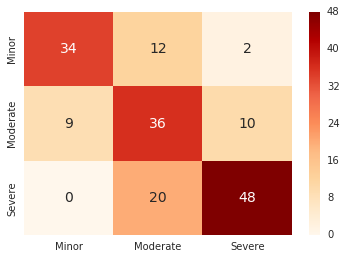

In [22]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

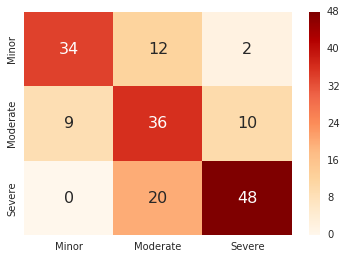

In [27]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

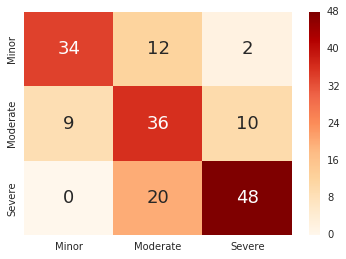

In [26]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

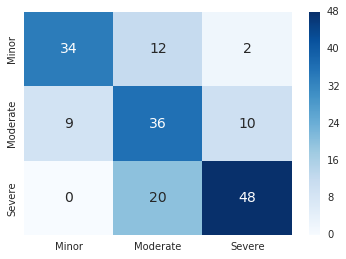

In [23]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

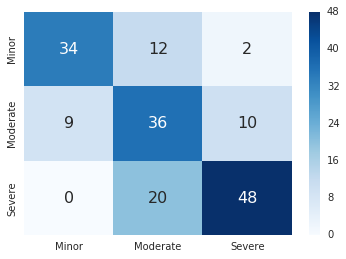

In [25]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

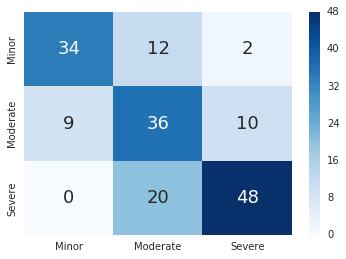

In [24]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [70]:
def severity_estimator(image_path, model):
    print "Determining severity of damage..."
    urllib.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    pred_label = np.argmax(pred, axis=1)
    
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.iterkeys():
        if pred_label[0] == key:
            print "Assessment: {} damage to vehicle".format(d[key])
    print "Severity assessment complete."

In [68]:
car_severity_estimator('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_d3_model3)

Determining severity of damage...
Assessment: Minor damage to vehicle
Severity assessment complete.


In [67]:
car_severity_estimator('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_d3_model3)

Determining severity of damage...
Assessment: Minor damage to vehicle
Severity assessment complete.


In [66]:
car_severity_estimator('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg', ft_d3_model3)

Determining severity of damage...
Assessment: Severe damage to vehicle
Severity assessment complete.


In [72]:
severity_estimator('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg', ft_d3_model3)

Determining severity of damage...
Assessment: Minor damage to vehicle
Severity assessment complete.


In [73]:
severity_estimator('https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcQsEqgcb4vdQlWgsE7EaxfMed5n-v3MzE5nzxdayWgreSTBt2z5', ft_d3_model3)

Determining severity of damage...
Assessment: Moderate damage to vehicle
Severity assessment complete.


## Looking at Edge Cases

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.79      0.71      0.75        48
          1       0.53      0.65      0.59        55
          2       0.80      0.71      0.75        68

avg / total       0.71      0.69      0.70       171




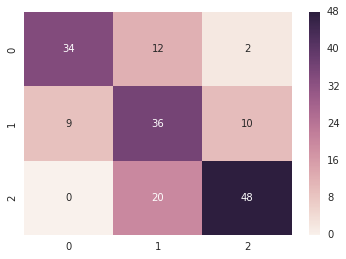

In [77]:
evaluate_categorical_model(ft_d3_model3, validation_data_dir, validation_labels)

In [83]:
def get_edge_cases(model, directory, exp_result, false_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred = model.predict(x)
        pred_label = np.argmax(pred, axis=1)
        if pred_label[0] == false_result:
            edge_list.append(name)
    return edge_list

In [88]:
minor1 = get_edge_cases(ft_d3_model3, 'data3_1/validation/01-minor/', 0, 1) # true minor, predicted moderate - 12
minor2 = get_edge_cases(ft_d3_model3, 'data3_1/validation/01-minor/', 0, 2) # true minor, predicted severe - 2

In [ ]:
moderate1 = get_edge_cases(ft_d3_model3, 'data3_1/validation/02-moderate/', 1, 0) # true moderate, predicted minor - 9
moderate2 = get_edge_cases(ft_d3_model3, 'data3_1/validation/02-moderate/', 1, 2) # true moderate, predicted severe - 10

In [89]:
severe1 = get_edge_cases(ft_d3_model3, 'data3_1/validation/03-severe/', 2, 0) # true severe, predicted minor - 0
severe2 = get_edge_cases(ft_d3_model3, 'data3_1/validation/03-severe/', 2, 1) # true severe, predicted moderate - 20

In [91]:
len(minor1) == 12, len(minor2) == 2, len(moderate1) == 9, len(moderate2) == 10, len(severe1) == 0, len(severe2) == 20

(True, True, True, True, True, True)

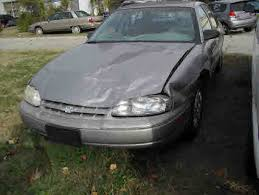

c to continue, q to quitc


In [93]:
view_images('data3_1/validation/01-minor/', minor1) # moderate

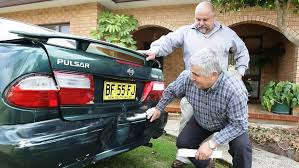

c to continue, q to quitc


In [94]:
view_images('data3_1/validation/01-minor/', minor2) # severe

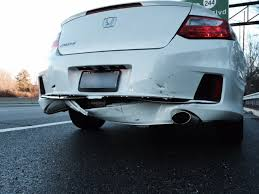

c to continue, q to quitc


In [95]:
view_images('data3_1/validation/02-moderate/', moderate1) # minor

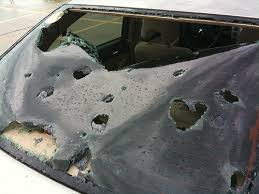

c to continue, q to quitc


In [96]:
view_images('data3_1/validation/02-moderate/', moderate2) # severe

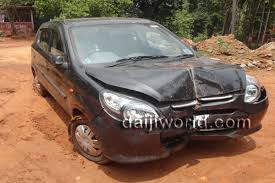

c to continue, q to quitq


'Finished for now.'

In [98]:
view_images('data3_1/validation/03-severe/', severe2) # moderate